# Game of Life
## Problem 14.6
##### Fred Bunt

In [4]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from scipy.ndimage import correlate


def init_random(shape, p=0.2):
    """Populate the state randomly using probability p """
    return (np.random.random(shape) < p).astype(np.uint8)


# https://www.conwaylife.com/wiki/Blinker
PATTERN_BLINKER = """
111
"""
# https://www.conwaylife.com/wiki/Pre-block
PATTERN_PREBLOCK = """
10
11
"""
# https://www.conwaylife.com/wiki/Glider
PATTERN_GLIDER = """
010
001
111
"""
# https://www.conwaylife.com/wiki/T-tetromino
PATTERN_TTETROMINO = """
111
010
"""
# https://www.conwaylife.com/wiki/R-pentomino
PATTERN_RPENTOMINO = """
011
110
010
"""
# https://www.conwaylife.com/wiki/Toad
PATTERN_TOAD = """
1110
0111
"""
# https://www.conwaylife.com/wiki/Pentadecathlon
PATTERN_PENTADECATHLON = """
11111111
10111101
11111111
"""
# https://www.conwaylife.com/wiki/Acorn
PATTERN_ACORN = """
0100000
0001000
1100111
"""
# https://www.conwaylife.com/wiki/24827M
PATTERN_24827M = """
00000010
00010100
10000100
01100000
00101000
00010000
00000111
"""
PATTERN_MAP = {
    "blinker": PATTERN_BLINKER,
    "preblock": PATTERN_PREBLOCK,
    "glider": PATTERN_GLIDER,
    "T": PATTERN_TTETROMINO,
    "R": PATTERN_RPENTOMINO,
    "toad": PATTERN_TOAD,
    "acorn": PATTERN_ACORN,
    "pent": PATTERN_PENTADECATHLON,
    "meth": PATTERN_24827M,
}


def pattern_to_grid(pat):
    pat = pat.strip()
    arr = []
    for line in pat.split():
        row = []
        for c in line:
            row.append(int(c))
        arr.append(row)
    arr = np.array(arr, dtype=np.uint8)
    return arr


def init_from_pattern(shape, pat):
    state = np.zeros(shape, dtype=np.uint8)
    pat = pattern_to_grid(pat)
    i, j = [x // 2 for x in shape]
    n, m = pat.shape
    istart = i - (n // 2)
    jstart = j - (m // 2)
    state[istart : istart + n, jstart : jstart + m] = pat
    return state


def density_calc(state):
    return state.sum() / state.size


NEIGHBOR_KERN = np.array(
    [
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ],
    dtype=np.uint8
)


class GOLSimulation:
    def __init__(self, initial_state, mode="wrap"):
        self.state = initial_state
        self.count = np.zeros_like(self.state)
        self.next_state = np.zeros_like(self.state)
        self.mode = mode
        self.density = [density_calc(initial_state)]
        self.density_t = []
        self.density_tp1 = []

    def step(self):
        self._step()
        self.density_t.append(density_calc(self.state))
        self.density_tp1.append(density_calc(self.next_state))
        # Swap to update current state
        self.state, self.next_state = self.next_state, self.state
        self.density.append(density_calc(self.state))
        return self.state

    def _step(self):
        self.next_state[:] = 0
        correlate(self.state, NEIGHBOR_KERN, output=self.count, mode=self.mode)
        dead = self.state == 0
        living = self.state == 1
        count3 = self.count == 3
        # Rules 2 & 3
        rule = living & ((self.count == 2) | count3)
        self.next_state[rule] = 1
        # Rule 4
        rule = dead & count3
        self.next_state[rule] = 1


class SimulationRunner:
    def __init__(self, sim, max_iter):
        self.sim = sim
        self.max_iter = max_iter

    def run(self):
        i = 1
        while i < self.max_iter:
            self.sim.step()
            i += 1


class SimulationAnimation:
    def __init__(self, sim, interval, max_iter, fig_size=(8, 8)):
        self.sim = sim
        self.fig = plt.figure(figsize=fig_size)
        self.im = None
        self.ani = None
        self.interval = interval
        self.max_iter = max_iter
        self.inited = False

    def init(self):
        self.im = plt.imshow(
            self.sim.state, interpolation="none", animated=True, cmap="gray"
        )
        plt.axis('off')
        return (self.im,)

    def update(self, *args):
        # Make sure that initial state is shown. Not sure if this is a jupyter bug
        if not self.inited:
            self.im.set_data(self.sim.state)
            self.inited = True
        else:
            self.sim.step()
            self.im.set_data(self.sim.state)
        return (self.im,)

    def run(self):
        self.ani = FuncAnimation(
            self.fig,
            self.update,
            frames=self.max_iter,
            init_func=self.init,
            interval=self.interval,
            blit=True,
        )
    
    def to_html(self):
        return HTML(self.ani.to_html5_video())
    
    
def show_state(sim):
    plt.figure(figsize=(10, 10))
    plt.imshow(sim.state, interpolation="none", cmap="gray")
    plt.axis('off')
    

def init(
    grid_size=400,
    prob=0.5,
    pat=None,
    boundary="wrap",
    max_iter=1000,
    interval=1,
    headless=True,
    fig_size=(8, 8),
):
    n = grid_size
    shape = (n, n)
    if pat is not None:
        state = init_from_pattern(shape, PATTERN_MAP[pat])
    else:
        state = init_random(shape, p=prob)
    sim = GOLSimulation(state, mode=boundary)
    runner = None
    if headless:
        runner = SimulationRunner(sim, max_iter)
    else:
        runner = SimulationAnimation(sim, interval, max_iter, fig_size)
    return sim, runner

## 14.6 a

Given a small number of initially living cells in an initial configuration,
there are few things that can happen. Some become simple oscillators like
the 1x3 "blinker". Some are stationary like the 2x2 block. Others explode
with activity like the "acorn" directly below. Many simpley fizzle out. A
few travel across the board like the "glider". These oscillate while propagating
across. The initial patterns that explode eventually reach a steady state
made of simple oscillators and stationary blocks and a few gliders roaming around.
For the stationary and oscillating patterns, the boundary conditions don't matter
unless the pattern is right on the edge. For the others, they matter a great deal.
Periodic boundary conditions let the expanding patterns continue to expand and even
interfere with themselves and allow the gliders to move endlessly.

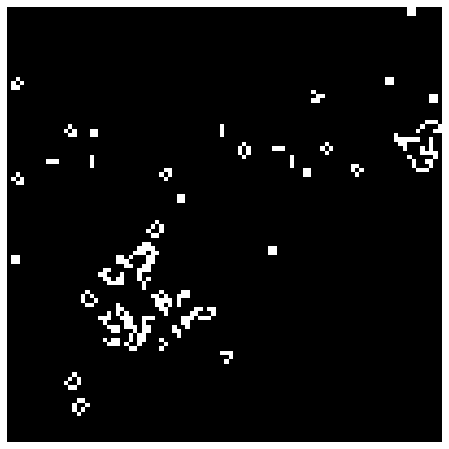

In [110]:
sim, runner = init(grid_size=100, max_iter=500, interval=100, pat="acorn", headless=False)
runner.run()
runner.to_html()

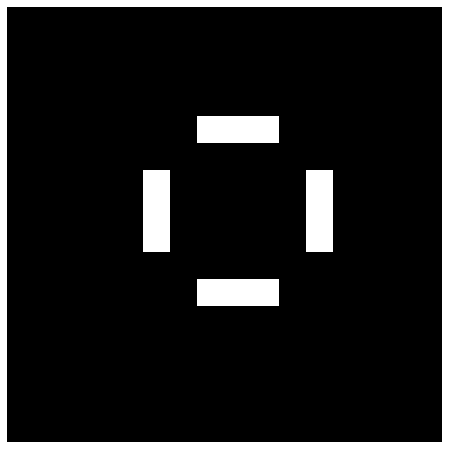

In [20]:
sim, runner = init(grid_size=16, max_iter=20, interval=300, pat="T", headless=False)
runner.run()
runner.to_html()

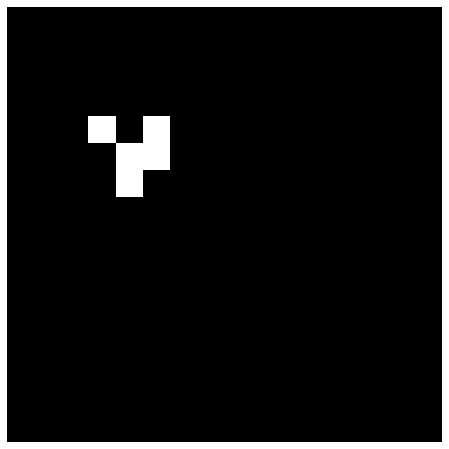

In [21]:
sim, runner = init(grid_size=16, max_iter=50, interval=300, pat="glider", headless=False)
runner.run()
runner.to_html()

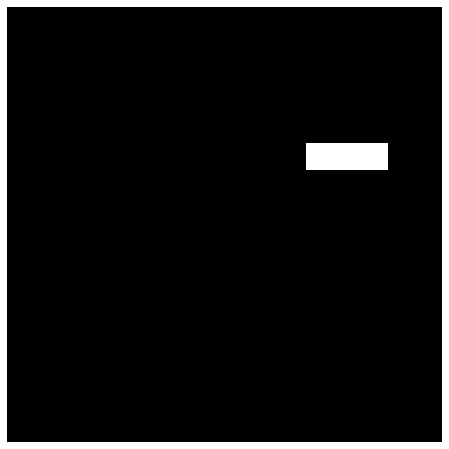

In [22]:
sim, runner = init(grid_size=16, max_iter=100, interval=300, pat="R", headless=False)
runner.run()
runner.to_html()

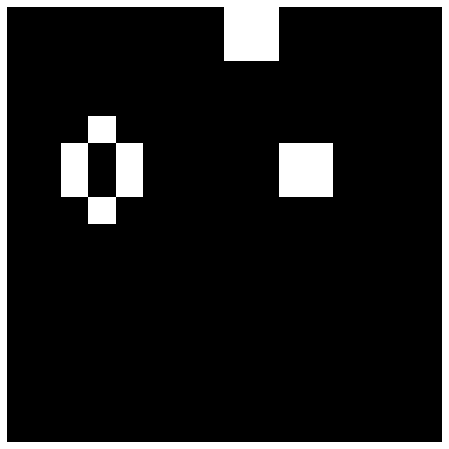

In [15]:
sim, runner = init(grid_size=16, max_iter=100, interval=300, pat="R", boundary="constant", headless=False)
runner.run()
runner.to_html()

## 14.6 b

Given an initial, random population of cells, the steady state seems to be small oscillators
like the "blinker" and small stationary groups like the 2x2 block. It can take a significant
amount of time and a lot of activity to reach the steady state though. And initial population of 50% reaches steady state fairly quickly, while one with 20% can take much longer. At 70%, the population dies off very rapidly due to overpopulation and then transitions to a long phase of sparse activity similar to the other starting probabilities. This eventually reaches the same steady state as the others.

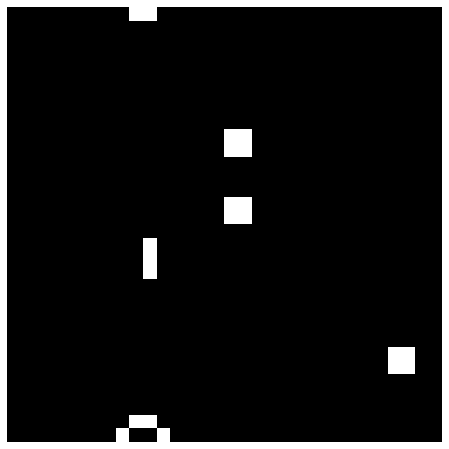

In [24]:
sim, runner = init(grid_size=32, prob=0.5, interval=100, max_iter=200, headless=False)
runner.run()
runner.to_html()

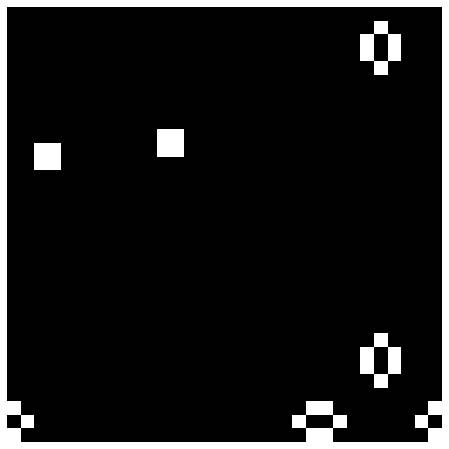

In [27]:
sim, runner = init(grid_size=32, prob=0.2, interval=100, max_iter=500, headless=False)
runner.run()
runner.to_html()

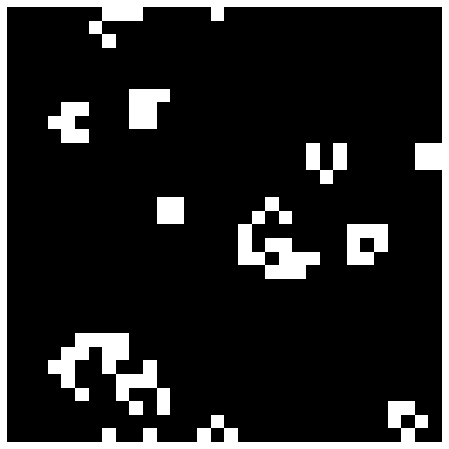

In [28]:
sim, runner = init(grid_size=32, prob=0.7, interval=100, max_iter=200, headless=False)
runner.run()
runner.to_html()

## 14.6 c

The density seems to spiral downward until the simulation reaches a steady state.
The steady state density for p = 0.5 is approximately 0.03. Interestingly, for a 100 x 100 grid,
simulations with p between 0.1 and 0.7 all reach a steady state density close to 0.03.

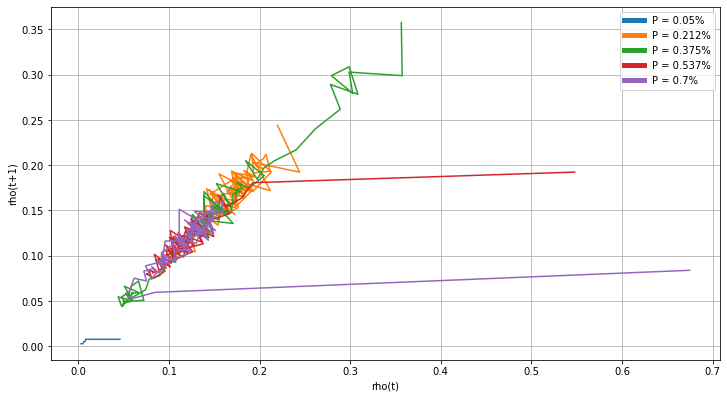

In [79]:
sims = []
n = 5
probs = np.linspace(0.05, 0.7, n)
for p in probs:
    s, r = init(grid_size=32, max_iter=100, prob=p)
    sims.append(s)
    r.run()
fig = plt.figure(figsize=(12, 12))
fig.add_subplot(111, aspect="equal")
for i, (s, p) in enumerate(zip(sims, probs)):
    plt.plot(s.density_t, s.density_tp1, label=f"P = {p:.3}%")
plt.xlabel("rho(t)")
plt.ylabel("rho(t+1)")
plt.grid()
leg = plt.legend(loc=0)
for handle in leg.legendHandles:
    handle.set_linewidth(5)

In [102]:
sims2 = []
n = 5
probs2 = np.linspace(0.05, 0.9, 20)
for p in probs2:
    s, r = init(grid_size=100, max_iter=10000, prob=p)
    sims2.append(s)
    r.run()

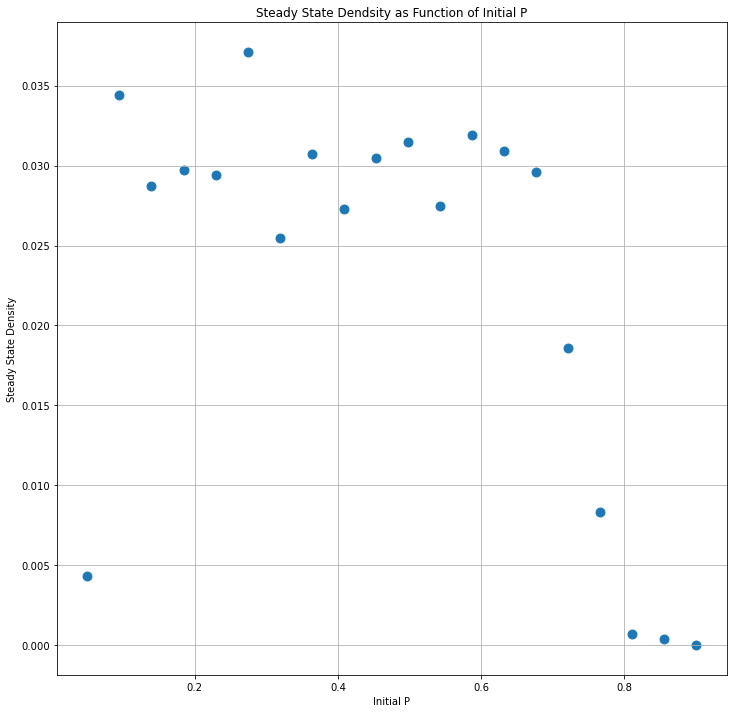

In [108]:
plt.figure(figsize=(12, 12))
yvals = [s.density[-1] for s in sims2]
plt.scatter(probs2, yvals, s=80)
plt.title("Steady State Dendsity as Function of Initial P")
plt.xlabel("Initial P")
plt.ylabel("Steady State Density")
plt.grid()